In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
#from mpl_toolkits.basemap import Basemap
#import folium
#from folium import plugins as f_plugins
#import fiona
import shapely
import pandas as pd
import seaborn as sns
import tables
import pickle
import glob
#except:
#    !pip install tables
#    import tables
#from datetime import datetime as dt
#from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.feature import ShapelyFeature
from cartopy.io.img_tiles import MapboxTiles
#from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from string import ascii_lowercase as alphabet

In [2]:
crowned_areas_SABRE_count = pd.read_pickle('./datasets/crowning_intersected_SABRE_count.pkl')
crowned_areas_SABRE = pd.read_pickle('./datasets/crowning_intersected_SABRE.pkl')

In [3]:
crowned_areas_SABRE['Time_obj'] = crowned_areas_SABRE.Time_obj.dt.tz_localize('Australia/Brisbane')

In [4]:
plot_set_timestamps_15M = pickle.load( open( "./datasets/plot_set_timestamps_15M.pickle", "rb" ) )

In [5]:
end = plot_set_timestamps_15M[0]
start = end - pd.Timedelta('15T')

In [6]:
crowned_areas_SABRE.columns

Index(['CELL_ID', 'S_SLOPE', 'S_ELEVTN', 'S_ASPECT', 'F_GRASS', 'F_SURFACE',
       'F_BARK', 'F_ELVTD', 'F_TOTAL', 'ROAD_PROX', 'DISRUPTION', 'HOUR_BURNT',
       'E_ROS', 'E_INTSTY', 'HOUR_SPOT', 'SPOT_DIST', 'EMBR_DNSTY',
       'SUPPRESSED', 'WENT_OUT', 'FLAME_HT', 'FLAME_DT', 'CONVECT', 'FMC',
       'FFDI', 'ASSET_ID', 'WIND_SPD', 'WIND_DIR', 'IMPACT_DIR', 'HL_PROB',
       'WIND_MOD', 'X_COORD', 'Y_COORD', 'geometry', 'Trial_Name', 'Time',
       'Grid_Type', 'Time_obj', 'index_right', 'OBJECTID', 'Crowned',
       'NotCrowned', 'SHAPE_Leng', 'SHAPE_Area', 'crowning_area'],
      dtype='object')

In [7]:
def get_crowning_timestamp(end,delta='15T'):
    start = end - pd.Timedelta(delta)
    mask = (crowned_areas_SABRE['Time_obj'] > start) & (crowned_areas_SABRE['Time_obj'] <= end)
    len(crowned_areas_SABRE.loc[mask])#.CELL_ID.unique()
    #print(crowned_areas_SABRE.Trial_Name.unique())
    crowning_timestep = crowned_areas_SABRE.loc[mask].copy()#.groupby(['CELL_ID']).sum()
    #print(crowning_timestep.Trial_Name.unique())
    crowning_timestep['Counts'] = crowning_timestep.groupby(['CELL_ID'])['CELL_ID'].transform('count')
    crowning_timestep=crowning_timestep.set_index('CELL_ID')
    crowning_timestep=crowning_timestep.drop_duplicates()
    #print(crowning_timestep.Counts.max())
    return crowning_timestep

#[get_crowning_timestamp(ts) for ts in plot_set_timestamps_15M]

In [8]:
df = get_crowning_timestamp(plot_set_timestamps_15M[-3])
crs_proj4 = {'init': 'EPSG:4326'}#ccrs.PlateCarree().proj4_init
crs_aus_equal_abler = {'init': 'EPSG:3577'}
df = df.to_crs(crs_proj4)

In [9]:
max_agreement = max([get_crowning_timestamp(ts).Counts.max() for ts in plot_set_timestamps_15M])
min_agreement = min([get_crowning_timestamp(ts).Counts.min() for ts in plot_set_timestamps_15M])

In [10]:
 with open("./mbox_key.txt", "r") as f:
        mbox_key = f.read()

In [11]:
def formatmap(ax,x=True,y=True):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_bottom = gl.ylabels_left = gl.xlabels_top = gl.ylabels_right = False
    if x:
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
    if y:
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER
    return ax

def apply_subplot_ticks(ax,x_custom=None,y_custom=None):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_bottom = gl.ylabels_left = gl.xlabels_top = gl.ylabels_right = False
    if ax in axs[-1]:
        if x_custom is not None:
            lon_formatter = LongitudeFormatter(number_format='.3f',dateline_direction_label=True)
            ax.set_xticks(x_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER

    if ax in axs[:,0]:
        if y_custom is not None:
            lat_formatter = LatitudeFormatter(number_format='.3f',dateline_direction_label=True)
            ax.set_xticks(y_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lat_formatter)
        else:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER
            

def parse_isochrone_source(filename):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    return ''.join(fn_list[-1])

def parse_isochrone_time(filename,origin_tz=None):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    strdate, strtime = ''.join(fn_list[1:4]), fn_list[4]
    dt = pd.to_datetime(strdate+strtime, format='%d%m%Y%H%M')
    if origin_tz is not None:
        dt = dt.tz_localize(tz=origin_tz)
        dt = dt.tz_convert('utc')
    else:
        dt = dt.tz_localize(tz='utc')
    return dt

def parse_isochrones(fls):
    isochrone_df = pd.DataFrame({'paths':fls})

    isochrone_df['source'] = isochrone_df['paths'].apply(parse_isochrone_source)

    final_isochrone = isochrone_df[isochrone_df.source == 'final']
    isochrone_df = isochrone_df[isochrone_df.source != 'final'].copy()

    isochrone_df['datetime'] = isochrone_df['paths'].apply(parse_isochrone_time,origin_tz='Australia/Brisbane')
    isochrone_df = isochrone_df.set_index(['datetime'])
    
    start_time = isochrone_df.index.min()
    end_time = isochrone_df.index.max()
    print('Data collection duration: {}'.format(end_time-start_time))
    
    return final_isochrone, isochrone_df

def load_shapefiles_into_gdf(isochrone_df):

    isochrones_gdf = gpd.GeoDataFrame()

    for dt, row in isochrone_df.iterrows():
        iso = gpd.read_file(row['paths'])
        iso['datetime'] = dt
        iso['source'] = row['source']
        if bool(iso.crs):
            isochrones_gdf = isochrones_gdf.append(iso)
        else: 
            print('File is missing crs: {}'.format(row['paths']))
            print('Skipping...')
        
    isochrones_gdf = isochrones_gdf[['geometry','datetime','source']].reset_index()
        
    return isochrones_gdf
def add_isochrones(ax,final_only=False,**final_kwargs):
    handles = []
    labels = []
    
    ax.add_geometries(final_gdf['geometry'],crs=ccrs.PlateCarree(),**final_kwargs)

    if 'facecolor' in final_kwargs.keys():
        handles.append(mpatches.Rectangle((0, 0), 1, 1, **final_kwargs))
    else:
        handles.append(Line2D([0], [0], **final_kwargs))
        
    labels.append('Final perimeter')
        
        
        
    if not final_only:

        color=iter(plt.cm.rainbow_r(np.linspace(0,1,len(isochrones_gdf))))
        for i, row in isochrones_gdf.iloc[::-1].iterrows():
            c=next(color)
            ax.add_geometries([row['geometry']],facecolor=c,crs=ccrs.PlateCarree())
            handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=c))
            labels.append('{} ({})'.format(row['datetime'].tz_convert(target_tz).strftime(time_str_format_map),row['source']))

    return handles, labels

In [12]:
fls = glob.glob('./datasets/Perimeter Shapefiles/*.shp')
fls.sort()
final_isochrone, isochrone_df = parse_isochrones(fls)
final_gdf = gpd.read_file(final_isochrone.iloc[0].paths)
isochrones_gdf = load_shapefiles_into_gdf(isochrone_df)

Data collection duration: 1 days 12:58:00
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_5_12_2016_1348_MODIS.shp
Skipping...
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_6_12_2016_1338_VIIRS.shp
Skipping...


In [13]:
buffer = 0.02
min_lon, min_lat, max_lon, max_lat = [151,-28.3,151.58,-28.04]
x0x1y0y1 = [final_gdf.bounds.iloc[0].minx-buffer, final_gdf.bounds.iloc[0].maxx+buffer, final_gdf.bounds.iloc[0].miny-buffer, final_gdf.bounds.iloc[0].maxy+buffer]



In [14]:
tiler = MapboxTiles(mbox_key,'outdoors')

In [35]:
fire_severity = gpd.read_file('./datasets/shapefiles/FireSeverity.shp')
crowned_areas = fire_severity[fire_severity['Crowned'] == 'Crowned']
green_areas = fire_severity[fire_severity['Crowned'] == 'Green']

area_gdf = final_gdf.to_crs(crs_aus_equal_abler)
total_area = area_gdf.unary_union.area * 0.0001
print('{} ha perimeter'.format(total_area))

blocks_gdf = crowned_areas.to_crs(crs_aus_equal_abler)
A_block = blocks_gdf.iloc[7]
B_block = blocks_gdf.iloc[6]
C_block = blocks_gdf.iloc[5]
print('Block A: {} ha crowned'.format(A_block.geometry.area * 0.0001))
print('Block B: {} ha crowned'.format(B_block.geometry.area * 0.0001))
print('Block C: {} ha crowned'.format(C_block.geometry.area * 0.0001))


area_gdf = crowned_areas.to_crs(crs_aus_equal_abler)
hectares_crowned = area_gdf.unary_union.area * 0.0001
print('{} ha crowned'.format(hectares_crowned))

area_gdf = green_areas.to_crs(crs_aus_equal_abler)
hecatres_green = area_gdf.unary_union.area * 0.0001
print('{} ha green canopy'.format(hecatres_green))
      
print('{} ha sorched'.format(total_area-hecatres_green-hectares_crowned))


crowned_areas = crowned_areas.to_crs(crs_proj4)
#crowned_areas = crowned_areas.unary_union

6459.755793056107 ha perimeter
Block A: 21.749037522043565 ha crowned
Block B: 24.556567280776868 ha crowned
Block C: 136.08877283816307 ha crowned
371.0939785877278 ha crowned
1445.1004643212875 ha green canopy
4643.561350147092 ha sorched


In [34]:
print('Block AB: {} ha crowned'.format((B_block.geometry.area+A_block.geometry.area) * 0.0001))


Block AB: 46.30560480282043 ha crowned


In [47]:
C_block.geometry.bounds[3]-C_block.geometry.bounds[1]

2083.994809840806

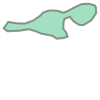

In [80]:
A_block.geometry

In [31]:
iso_kwargs={'lw':2,'edgecolor':'grey','facecolor':'none','alpha':0.5}

fig = plt.figure(figsize=(20,10))
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
#ax.add_image(tiler, 15,interpolation='bilinear')
ax.add_geometries(crowned_areas,edgecolor='grey',facecolor='grey',crs=ccrs.PlateCarree(),alpha=0.5)

#ax.add_geometries(df['geometry'],edgecolor='black',facecolor='red',crs=ccrs.PlateCarree())
ax.add_geometries(crowned_areas_SABRE.unary_union,edgecolor='none',facecolor='red',crs=ccrs.PlateCarree(),alpha=0.5)
handles, labels = add_isochrones(ax,final_only=True,**iso_kwargs)
ax = formatmap(ax)
plt.show()

AttributeError: 'str' object has no attribute '_geom'

<Figure size 1440x720 with 1 Axes>

In [23]:
buffer = 0.02
bounds = crowned_areas_SABRE.to_crs(crs_proj4).bounds.iloc[0]
x0x1y0y1 = [bounds.minx-buffer, bounds.maxx+buffer, bounds.miny-buffer, bounds.maxy+0.005]


In [24]:
x0x1y0y1

[151.04274157787037,
 151.08308987204094,
 -28.212332044857714,
 -28.18702346242628]

In [32]:
iso_kwargs={'lw':2,'edgecolor':'grey','facecolor':'none','alpha':0.5}

fig = plt.figure(figsize=(20,10))
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
ax.add_image(tiler, 15,interpolation='bilinear')
ax.add_geometries(crowned_areas,edgecolor='grey',facecolor='grey',crs=ccrs.PlateCarree(),alpha=0.5)


color=iter(plt.cm.magma(np.linspace(0,1,max_agreement)))
for i in range(max_agreement):
    c=next(color)
    ax.add_geometries(df[df['Counts']==i+1]['geometry'],edgecolor='none',facecolor=c,crs=ccrs.PlateCarree())
handles, labels = add_isochrones(ax,final_only=True,**iso_kwargs)
ax = formatmap(ax)

plt.show()

AttributeError: 'str' object has no attribute '_geom'

<Figure size 1440x720 with 1 Axes>

In [26]:
context_map = {'bbox':x0x1y0y1,'data':crowned_areas}
pickle.dump(context_map, open( "./datasets/crownfire_contextmap.pickle", "wb" ))

In [222]:
pickle.load(open("./datasets/crownfire_contextmap.pickle", "rb" ))

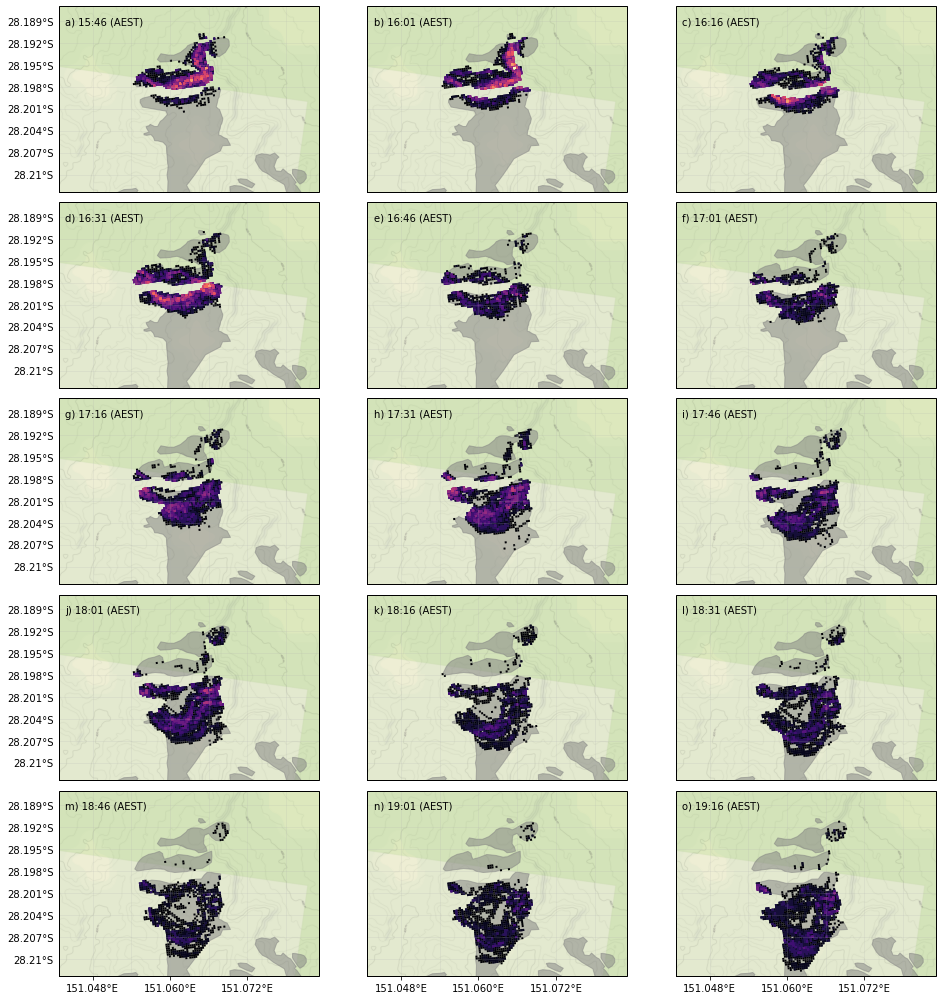

In [223]:
tiles = True
save = True
nrow = 5; ncol = 3;
assert nrow*ncol == len(plot_set_timestamps_15M)
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format = '%H:%M'
time_str_format_map = '%d/%m/%Y %H:%M'
save_str = './SABRE_crownfire.png'

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(14,14),sharex=True,subplot_kw={'projection': mercator})

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
    if tiles:
        ax.add_image(tiler, 15,interpolation='bilinear')

    #Load crowning for this timestep
    df = get_crowning_timestamp(plot_set_timestamps_15M[i])
    crs_proj4 = ccrs.PlateCarree().proj4_init
    df = df.to_crs(crs_proj4)
        
    #
    ax.add_geometries(crowned_areas,edgecolor='grey',facecolor='grey',crs=ccrs.PlateCarree(),alpha=0.5)
    #ax.add_geometries(df['geometry'],edgecolor='none',facecolor='red',crs=ccrs.PlateCarree())
    
    color=iter(plt.cm.magma(np.linspace(0,1,max_agreement)))
    for k in range(max_agreement):
        c=next(color)
        ax.add_geometries(df[df['Counts']==k+1]['geometry'],edgecolor='none',facecolor=c,crs=ccrs.PlateCarree())
    
    #Formatting
    apply_subplot_ticks(ax,x_custom=[151.048, 151.06, 151.072])
    ds_string = '{} ({})'.format(plot_set_timestamps_15M[i].tz_convert(target_tz).strftime(time_str_format),
                                 target_tz_name)
    ax.text(.025,.9,'{}) {}'.format(alphabet[i],ds_string),
        horizontalalignment='left',
        transform=ax.transAxes)
    #handles, labels = add_isochrones(ax)

fig.canvas.draw()
plt.tight_layout()
#cbar_ax = fig.add_axes([0.99, 0.15, 0.025, 0.7])
#im.plot_colorbar(cax=cbar_ax,label='$\mathregular{\mathit{Z_{H}}}$ (dBZ)')

#fig.legend(handles,labels,ncol=4, bbox_to_anchor=(0, 1),loc='lower left')

if save:
    plt.savefig(save_str,dpi=300)
plt.show()

/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


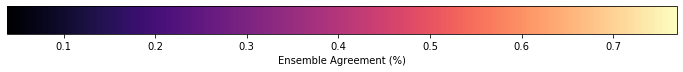

In [227]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.magma#(np.linspace(0,1,max_agreement))
norm = mpl.colors.Normalize(vmin=1/26, vmax=max_agreement/26)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Ensemble Agreement (%)')
plt.savefig('crowning_colorbar.png',dpi=300)
fig.show()